In [17]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error


In [18]:
# Charger les données prétraitées
df = pd.read_csv("../preprocessing/preprocessed_timeseries.csv", parse_dates=True, index_col=0)

# S'assurer que l'index est une colonne de type datetime
df.index = pd.to_datetime(df.index)

# Identifier les colonnes cibles (toutes sauf la date)
target_columns = df.columns[-1]

# Dictionnaire pour stocker les prédictions
forecast_results = {}
type(df)


pandas.core.frame.DataFrame

In [19]:
train_size = int(len(df) * 0.8)
train, test = df[:train_size], df[train_size:]

In [20]:
X_train = train.drop(columns=[df.columns[-1]])
y_train = train[df.columns[-1]]
X_test = test.drop(columns=[df.columns[-1]])
y_test = test[df.columns[-1]]


In [21]:
# Create a DMatrix for efficient computation
dtrain = xgb.DMatrix(X_train, label=y_train, enable_categorical=True)
dtest = xgb.DMatrix(X_test, label=y_test, enable_categorical=True)

# Define model parameters
params = {
    "objective": "reg:squarederror",
    "eval_metric": "rmse",
    "tree_method": "hist",  # Efficient for large datasets
}

# Train the model
model = xgb.train(params, dtrain, num_boost_round=100, evals=[(dtest, "test")], early_stopping_rounds=10)

# Predict
y_pred = model.predict(dtest)

# Evaluate
rmse = mean_squared_error(y_test, y_pred, squared=False)
print(f"Test RMSE: {rmse}")


[0]	test-rmse:18005892.07601
[1]	test-rmse:13019644.20465
[2]	test-rmse:9414204.02135
[3]	test-rmse:6807194.02188
[4]	test-rmse:4922123.97648
[5]	test-rmse:3559074.00811


[6]	test-rmse:2573483.95128
[7]	test-rmse:1740668.00441
[8]	test-rmse:1258636.02150
[9]	test-rmse:910090.00951
[10]	test-rmse:658065.98847
[11]	test-rmse:475832.00746
[12]	test-rmse:344064.00000
[13]	test-rmse:248784.00360
[14]	test-rmse:179889.99732
[15]	test-rmse:130074.00134
[16]	test-rmse:94053.99913
[17]	test-rmse:68007.99953
[18]	test-rmse:49175.99935
[19]	test-rmse:35557.99949
[20]	test-rmse:25712.00000
[21]	test-rmse:18592.00000
[22]	test-rmse:13444.00000
[23]	test-rmse:9721.99979
[24]	test-rmse:7030.00000
[25]	test-rmse:5084.00000
[26]	test-rmse:3676.00000
[27]	test-rmse:2658.00000
[28]	test-rmse:1922.00000
[29]	test-rmse:1390.00000
[30]	test-rmse:1006.00000
[31]	test-rmse:736.00000
[32]	test-rmse:532.00000
[33]	test-rmse:430.00000
[34]	test-rmse:344.00000
[35]	test-rmse:252.00000
[36]	test-rmse:172.00000
[37]	test-rmse:176.00000
[38]	test-rmse:122.00000
[39]	test-rmse:74.00000
[40]	test-rmse:56.00000
[41]	test-rmse:48.00000
[42]	test-rmse:56.00000
[43]	test-rmse:30.00000
[44]

C:\Users\raedb\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [22]:
latest_data = df.drop(columns=[df.columns[-1]])
print(type(latest_data))
latest_dmatrix = xgb.DMatrix(latest_data)
next_prediction = model.predict(latest_dmatrix)
print(f"Next time step prediction: {next_prediction[0]}")


<class 'pandas.core.frame.DataFrame'>
Next time step prediction: 30024420.0


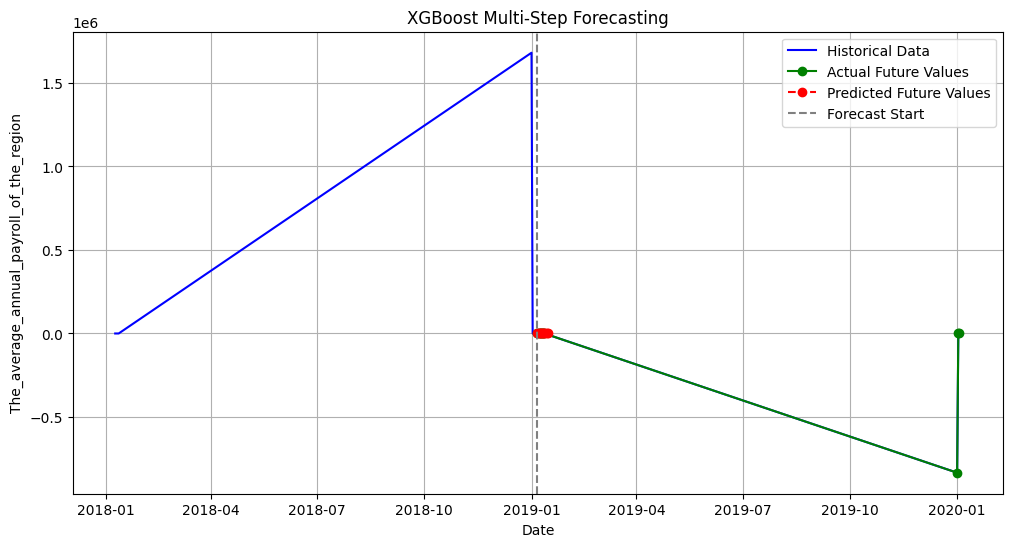

In [25]:
import numpy as np
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

def xgboost_forecast_with_graph(df, target_col, n_lags=10, n_steps=5, test_size=0.2):
    """
    Multi-step forecasting using XGBoost with a time-series plot.

    Parameters:
    - df (pd.DataFrame): Time series dataframe with DateTime index.
    - target_col (str): Name of the column to predict.
    - n_lags (int): Number of past time steps to use as features.
    - n_steps (int): Number of future time steps to predict.
    - test_size (float): Fraction of data to be used as test set.

    Returns:
    - y_pred (np.array): Predicted values.
    - y_test (np.array): Actual values.
    - forecast_dates (pd.DatetimeIndex): Dates for the forecast.
    """

    # Ensure datetime index
    df = df.copy()
    df = df.sort_index()

    # Create lag features
    for lag in range(1, n_lags + 1):
        df[f"lag_{lag}"] = df[target_col].shift(lag)

    df.dropna(inplace=True)  # Remove NaNs caused by shifting

    # Define input features (X) and target (y)
    X = df.drop(columns=[target_col])
    y = df[target_col]

    # Split into train-test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, shuffle=False)

    # Scale features (not the target)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Train XGBoost model
    model = xgb.XGBRegressor(objective="reg:squarederror", n_estimators=100, learning_rate=0.1)
    model.fit(X_train_scaled, y_train)

    # Multi-step forecasting (Recursive strategy)
    y_pred = []
    input_features = X_test_scaled[0].reshape(1, -1)
    forecast_dates = pd.date_range(start=X_test.index[0], periods=n_steps, freq="D")

    for _ in range(n_steps):
        pred = model.predict(input_features)[0]
        y_pred.append(pred)

        # Update input features by shifting and adding the new prediction
        input_features = np.roll(input_features, shift=-1)
        input_features[0, -1] = pred

    # y_pred = pd.DataFrame(y_pred, index=y_test.index)
    y_test = y_test[:n_steps]  # Get the actual values for comparison

    # Plot actual vs. predicted values over time
    plt.figure(figsize=(12, 6))
    plt.plot(df.index[-len(y_test)-n_steps:], df[target_col][-len(y_test)-n_steps:], label="Historical Data", color="blue")
    plt.plot(y_test.index, y_test, label="Actual Future Values", marker="o", color="green")
    plt.plot(forecast_dates, y_pred, label="Predicted Future Values", linestyle="--", marker="o", color="red")
    plt.axvline(x=y_test.index[0], color="gray", linestyle="--", label="Forecast Start")
    plt.xlabel("Date")
    plt.ylabel(target_col)
    plt.legend()
    plt.title("XGBoost Multi-Step Forecasting")
    plt.grid()
    plt.show()

    return y_pred, y_test, forecast_dates


y_pred, y_test, forecast_dates = xgboost_forecast_with_graph(df, target_col=df.columns[-1], n_lags=10, n_steps=10)


In [ ]:
y_pred

[-0.12634727,
 -0.12634727,
 -0.12634727,
 -0.12634727,
 -0.12634727,
 -0.12634727,
 -0.12634727,
 -0.12634727,
 -0.12634727,
 -0.12634727]

In [ ]:
y_test

Period
2019-01-06         0.0
2019-01-07         0.0
2019-01-08         0.0
2019-01-09         0.0
2019-01-10         0.0
2019-01-11         0.0
2019-01-12         0.0
2020-01-01   -833527.0
2020-01-02         0.0
2020-01-03         0.0
Name: The_average_annual_payroll_of_the_region, dtype: float64